In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
from gp_model import harmonic_sho_model
from hls import HarmonicLombScargle
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm

sns.set_theme(context='notebook', style='ticks', palette='colorblind')

In [3]:
search_result = lk.search_lightcurve('KIC 5111207')
lcs = [sr.download() for sr in tqdm(search_result)]

100%|██████████| 14/14 [00:00<00:00, 21.33it/s]


In [4]:
times = [lc.time.value for lc in lcs]
fluxes = [lc.flux.value for lc in lcs]
flux_errs = [lc.flux_err.value for lc in lcs]
masks = [~f.mask for f in fluxes]

times = [t[m] for t, m in zip(times, masks)]
fluxes = [f[m] for f, m in zip(fluxes, masks)]
flux_errs = [f[m] for f, m in zip(flux_errs, masks)]

quarters = [float(i)*np.ones_like(t) for (i, t) in enumerate(times)]

times = np.concatenate(times).astype(np.float64)
fluxes = np.array(np.concatenate(fluxes).astype(np.float64))
flux_errs = np.array(np.concatenate(flux_errs).astype(np.float64))
quarters = np.concatenate(quarters)

uquarters, quarter_indices = np.unique(quarters, return_inverse=True)

In [5]:
hls = HarmonicLombScargle(times, fluxes, quarters, 3)

In [6]:
fgrid = hls.relative_frequency_grid(0.05)
logls = hls.logl_on_grid(fgrid)

  0%|          | 0/215 [00:00<?, ?it/s]/Users/wfarr/Code/harmonic-lomb-scargle/hls.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, (rss,), _, _ = np.linalg.lstsq(M, self.flux)
100%|██████████| 215/215 [00:02<00:00, 73.29it/s]


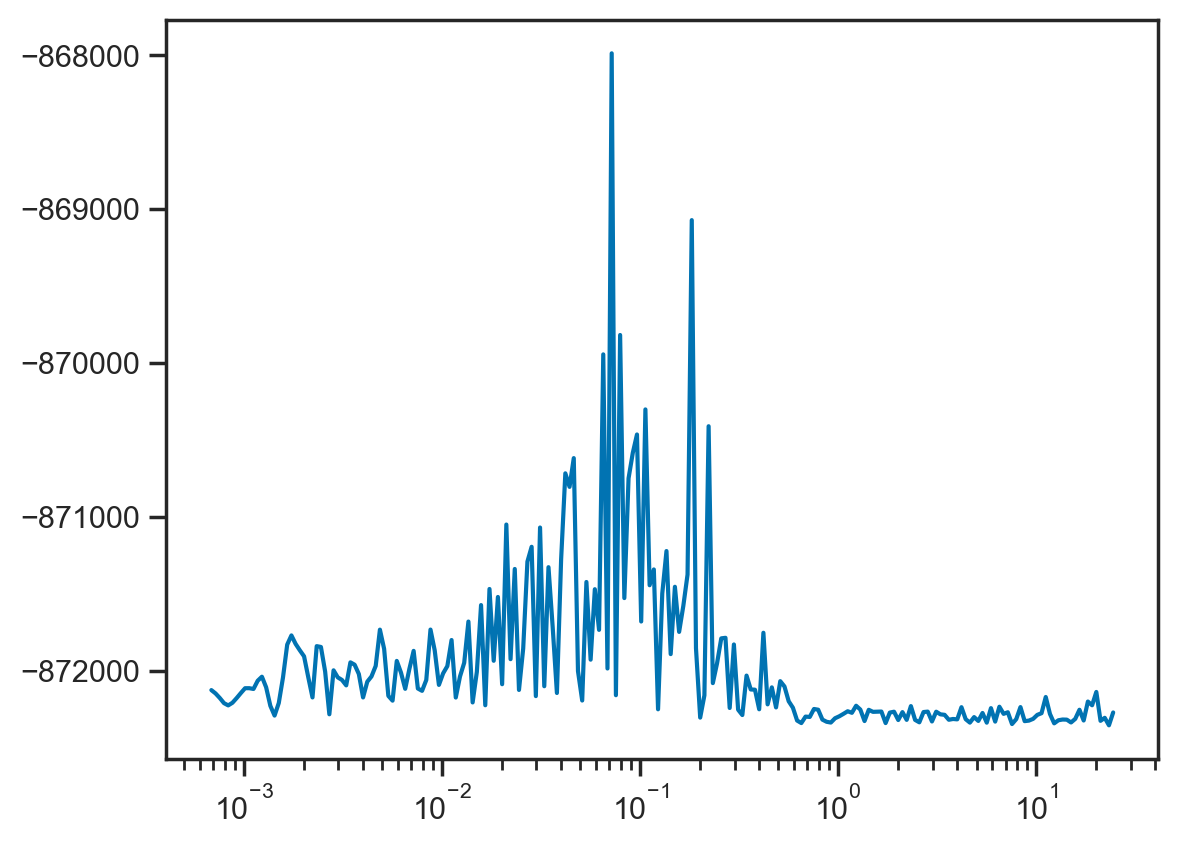

In [7]:
plt.plot(fgrid, logls)
plt.xscale('log')

100%|██████████| 215/215 [00:03<00:00, 59.47it/s]


(1, 100)

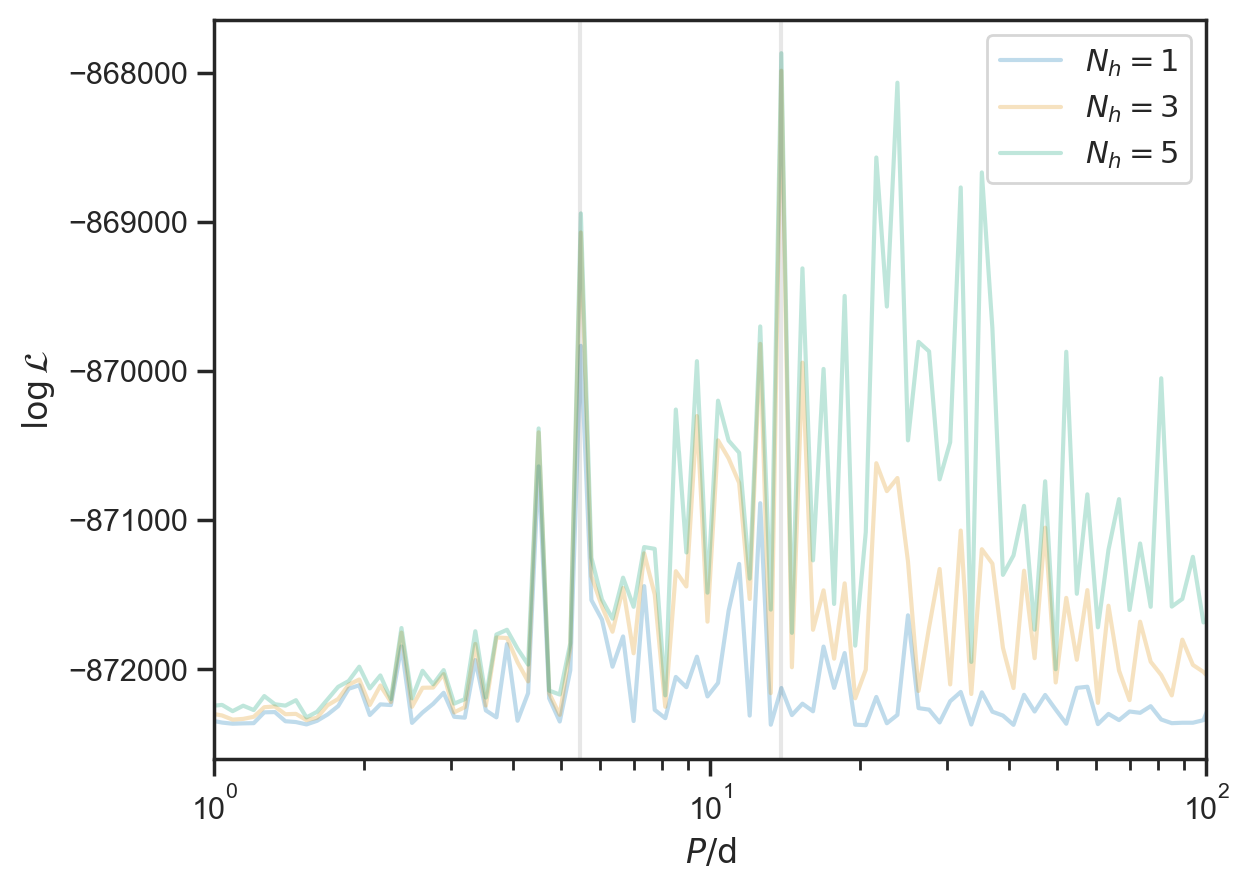

In [8]:
for nh in [1, 3, 5]:
    h = HarmonicLombScargle(times, fluxes, quarters, nh)
    fgrid = h.relative_frequency_grid(0.05)
    logls = h.logl_on_grid(fgrid)
    plt.plot(1/fgrid, logls, label=r'$N_h = {:d}$'.format(nh), alpha=0.25)
plt.xscale('log')
plt.xlabel(r'$P / \mathrm{d}$')
plt.ylabel(r'$\log \mathcal{L}$')
plt.legend()
plt.axvline(5.47, color='k', alpha=0.1)
plt.axvline(13.91, color='k', alpha=0.1)
plt.xlim(1, 100)

In [9]:
f_guess = fgrid[np.argmax(logls)]

fgrid_fine = hls.fine_frequency_grid(f_guess, 128)
logls_fine = hls.logl_on_grid(fgrid_fine)

100%|██████████| 128/128 [00:01<00:00, 72.77it/s]


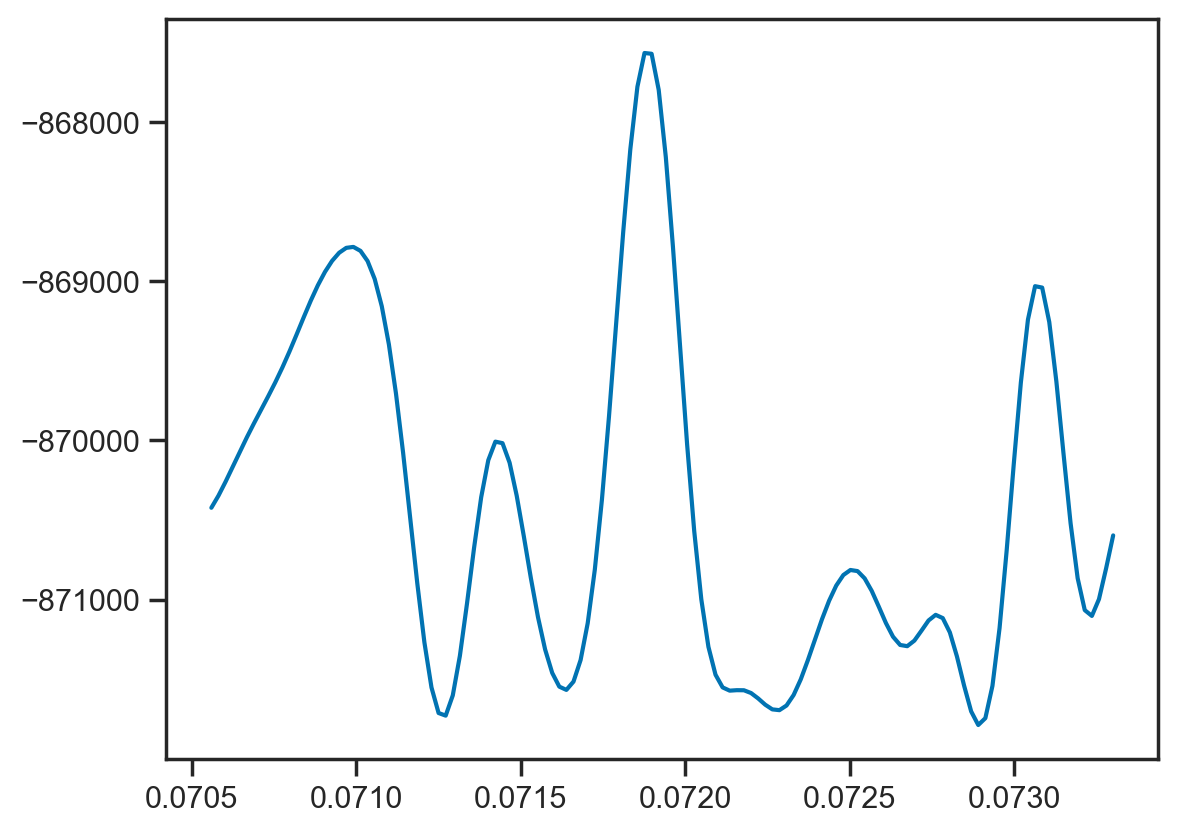

In [10]:
plt.plot(fgrid_fine, logls_fine)

In [11]:
f_best = hls.interpolated_best_frequency(fgrid_fine, logls_fine)
x_best = hls.best_fit_params(f_best)

print(f'f_best = {f_best}/day, or P = {1/f_best} days')

f_best = 0.07188693293022917/day, or P = 13.910733971229005 days


In [12]:
f_best_literature = 1/5.47

/Users/wfarr/Code/harmonic-lomb-scargle/hls.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, (rss,), _, _ = np.linalg.lstsq(M, self.flux)


Text(0, 0.5, 'Residuals [e- / s]')

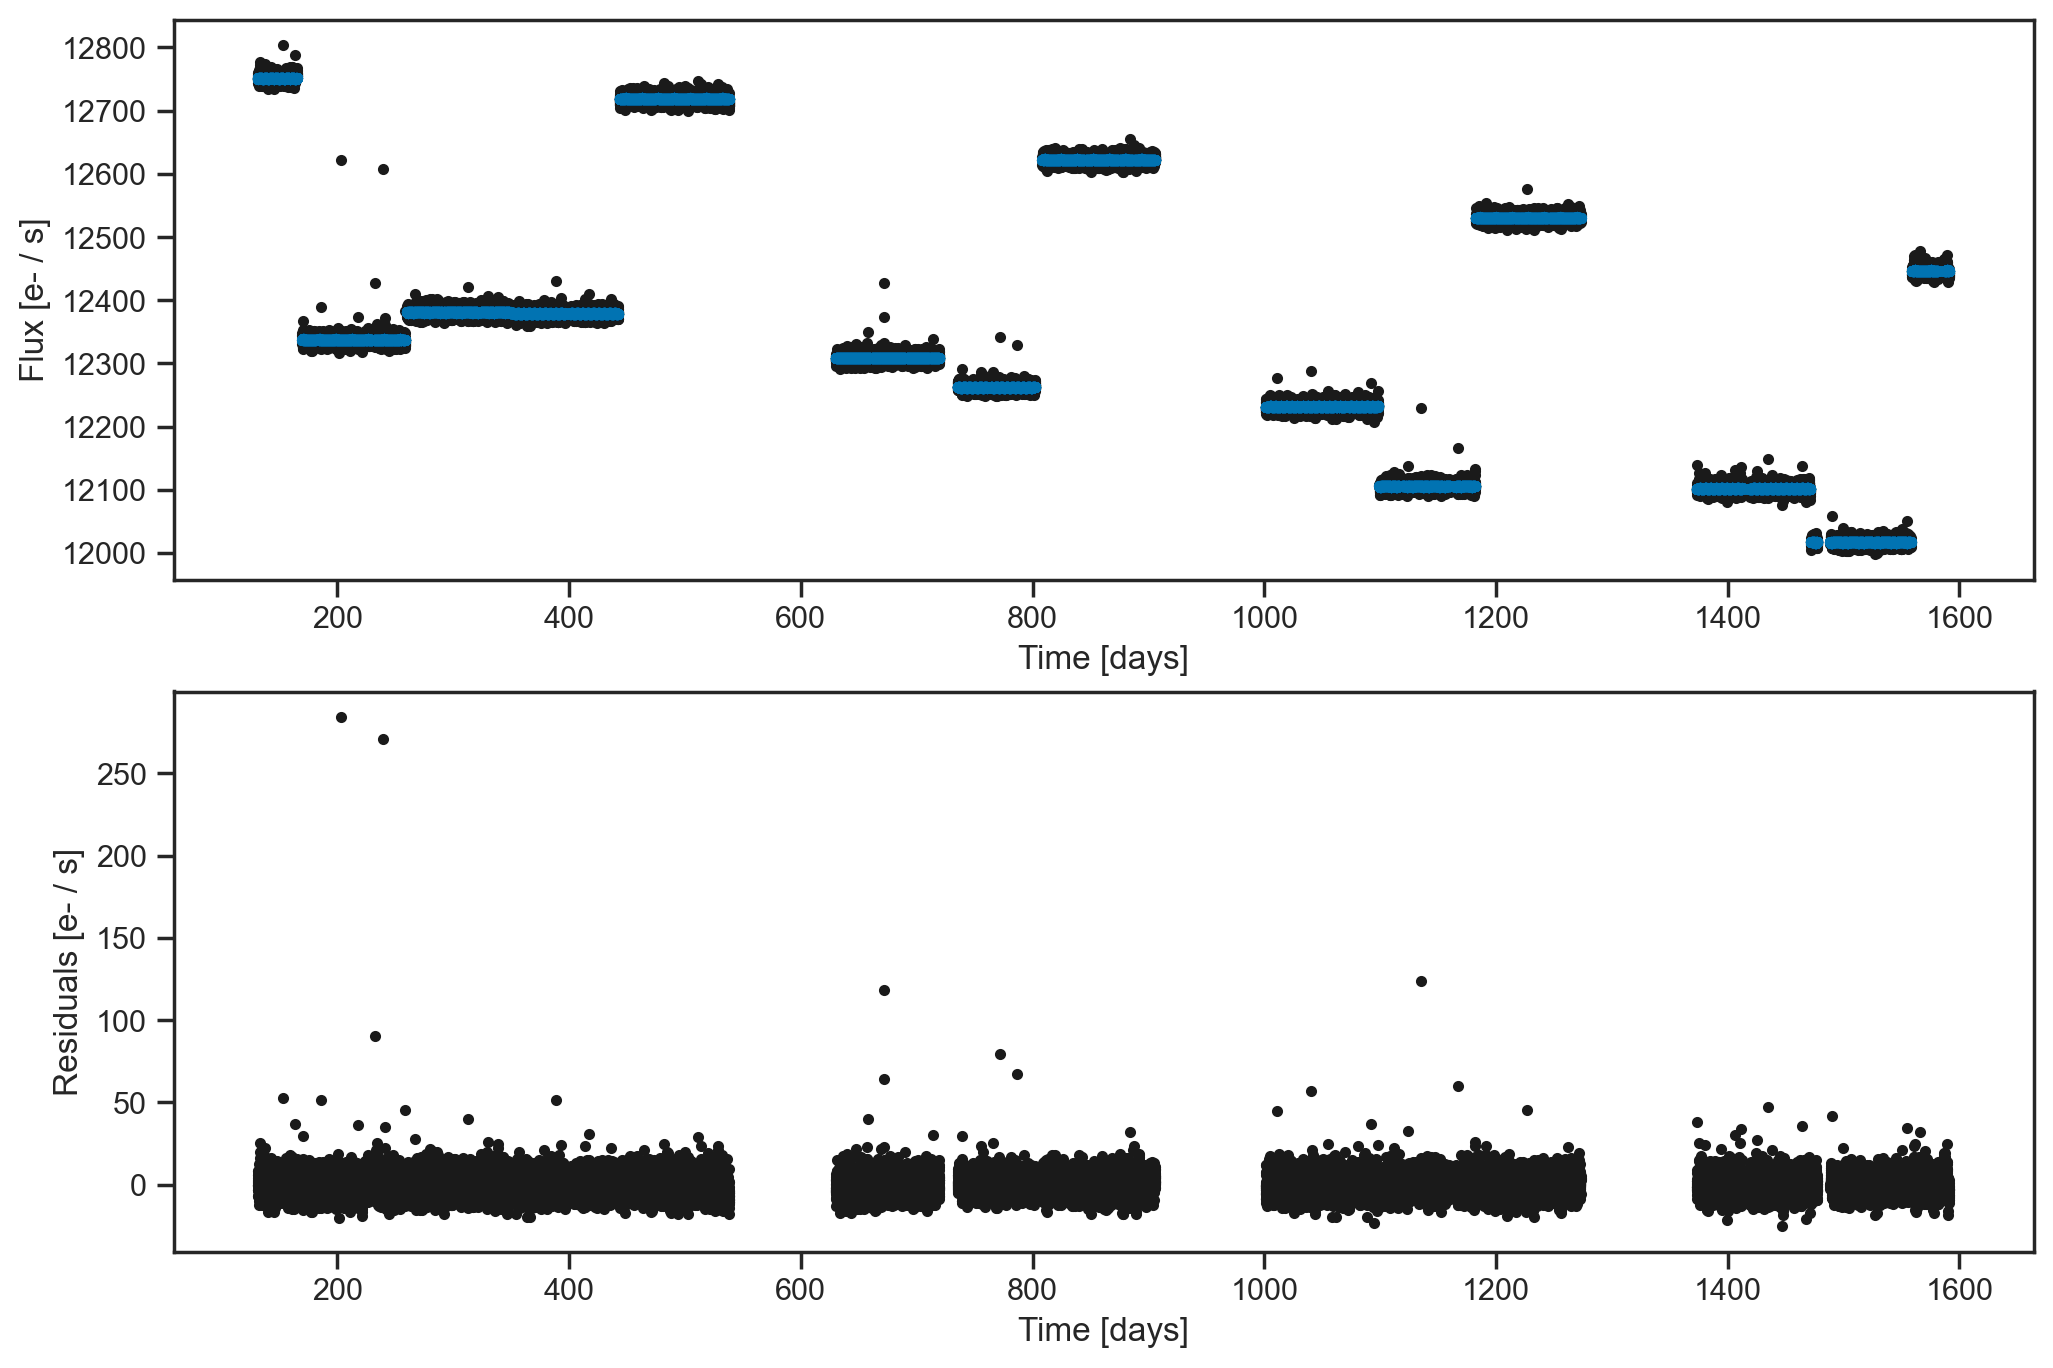

In [13]:
y = hls.predict_flux(f_best)

fig, subplots = plt.subplots(2, 1, figsize=(12, 8))

subplots[0].plot(times, fluxes, '.k')
subplots[0].plot(times, y, '.')
subplots[0].set_xlabel('Time [days]')
subplots[0].set_ylabel('Flux [e- / s]')

subplots[1].plot(times, fluxes - y, '.k')
subplots[1].set_xlabel('Time [days]')
subplots[1].set_ylabel('Residuals [e- / s]')

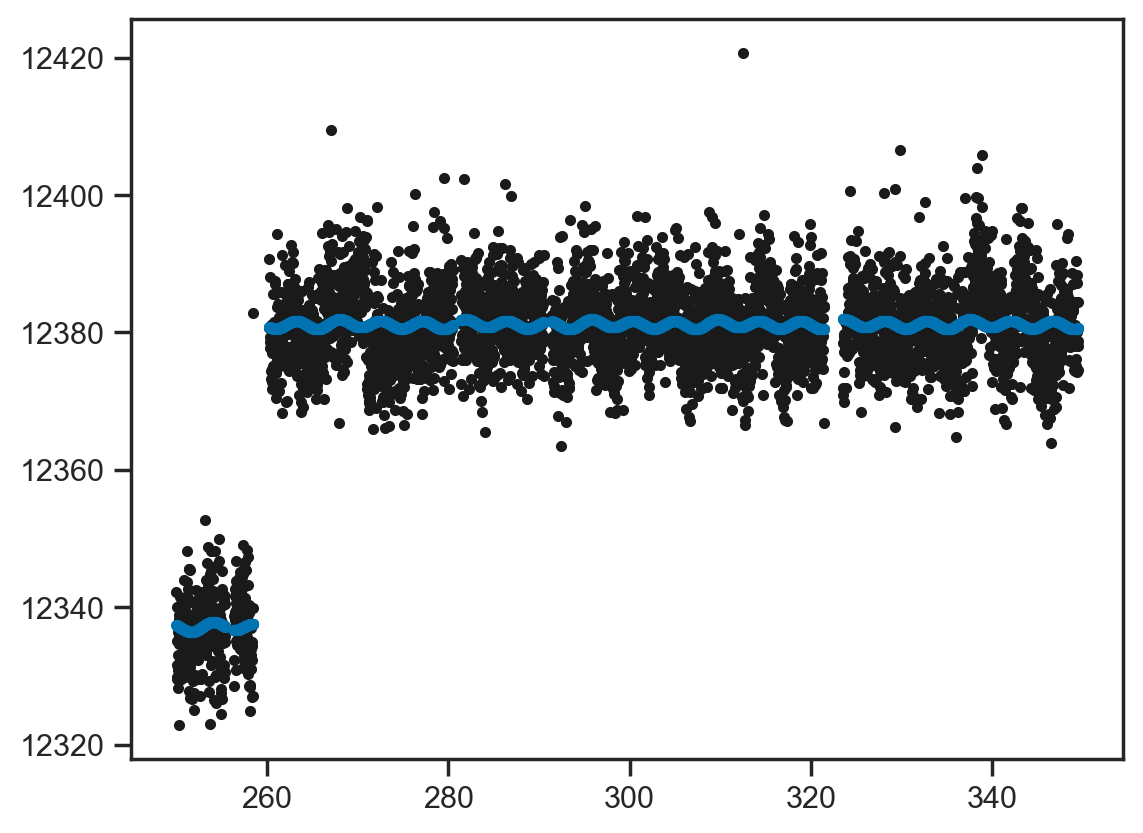

In [14]:
sel = np.abs(times - 300) < 50
plt.plot(times[sel], fluxes[sel], '.k')
plt.plot(times[sel], y[sel], '.')

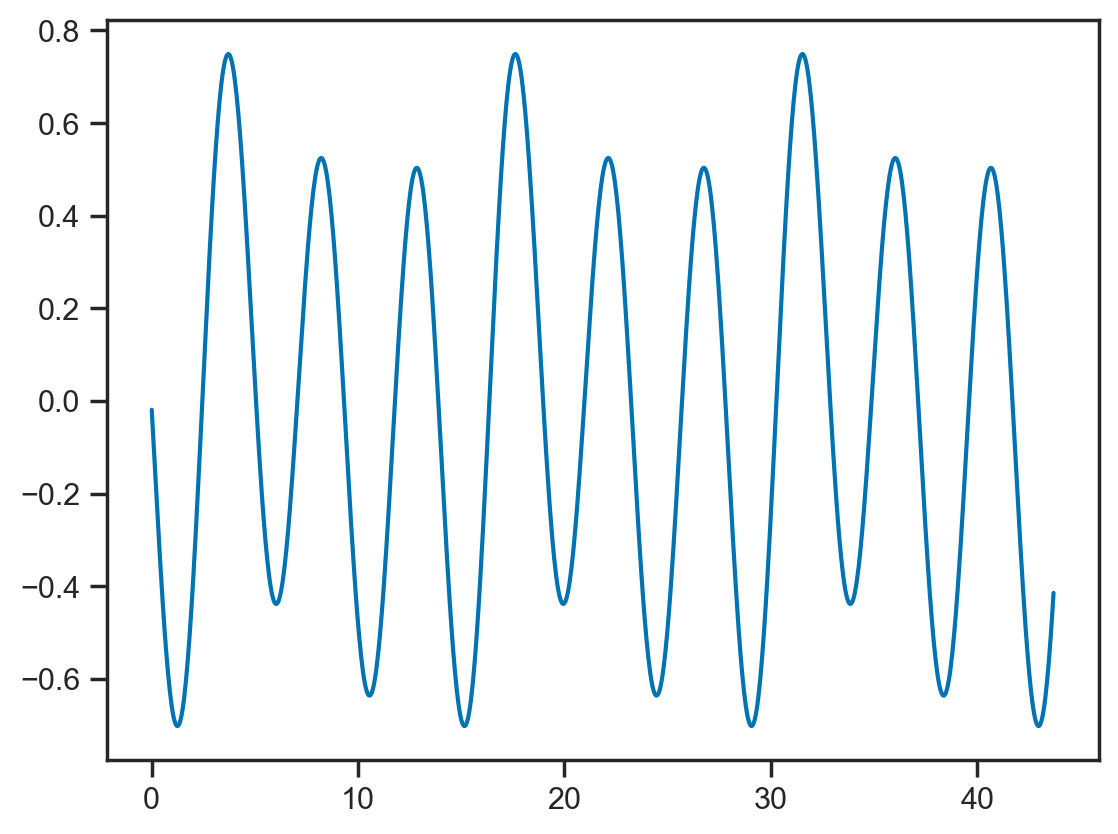

In [15]:
ts = np.linspace(0, np.pi*1/f_best, 1000)
plt.plot(ts, hls.periodic_lightcurve(ts, f_best, x_best))

Now let's try fitting some GP models.

In [16]:
n_in_quarters = np.bincount(quarter_indices)
quarter_means = np.bincount(quarter_indices, weights=fluxes) / n_in_quarters
quarter_vars = np.bincount(quarter_indices, weights=(fluxes - quarter_means[quarter_indices])**2) / n_in_quarters
quarter_stds = np.sqrt(quarter_vars)

total_var = np.sum(quarter_vars * n_in_quarters) / np.sum(n_in_quarters)
total_std = np.sqrt(total_var)

In [17]:
white_noise_variance = np.sum(flux_errs**2) / len(flux_errs)

In [18]:
dt = times[1]-times[0]
fny = 0.5 / dt
T = times[-1] - times[0]
df = 1/T

frequencies = np.arange(df, fny, df)

In [49]:
harmonics = [1] # Only the first harmonic for our first fit, we also provide a large uncertainty because we aren't really sure where the peak is.
thin_data = 1 # Set this to, say, 30 to thin the data by a factor of 30, improving runtime considerably.
model = harmonic_sho_model(times[::thin_data], fluxes[::thin_data], flux_errs[::thin_data], quarters[::thin_data], f_best, harmonics, quarter_means, quarter_stds, total_std, psd_freq=frequencies, predict_times=times[::thin_data], f_frac_uncert=1)

In [50]:
trace = pm.sample(tune=1000, draws=1000, cores=4, chains=4, model=model, progressbar=True, jitter_max_retries=100, init='adapt_full')

Initializing NUTS using adapt_full...
/Users/wfarr/miniconda3/envs/harmonic-lomb-scargle/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:760: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mus_scaled, log_fs_scaled, log_Qs_scaled, log_sigma_scaled]


Output()

/Users/wfarr/miniconda3/envs/harmonic-lomb-scargle/lib/python3.11/site-packages/pymc/step_methods/hmc/integration.py:133: RuntimeWarning: invalid value encountered in subtract
  energy = kinetic - logp
/Users/wfarr/miniconda3/envs/harmonic-lomb-scargle/lib/python3.11/site-packages/pymc/step_methods/hmc/integration.py:133: RuntimeWarning: invalid value encountered in subtract
  energy = kinetic - logp
/Users/wfarr/miniconda3/envs/harmonic-lomb-scargle/lib/python3.11/site-packages/pymc/step_methods/hmc/integration.py:133: RuntimeWarning: invalid value encountered in subtract
  energy = kinetic - logp


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 205 seconds.


array([[<Axes: title={'center': 'mus'}>, <Axes: title={'center': 'mus'}>],
       [<Axes: title={'center': 'fs'}>, <Axes: title={'center': 'fs'}>],
       [<Axes: title={'center': 'Qs'}>, <Axes: title={'center': 'Qs'}>],
       [<Axes: title={'center': 'sigmas'}>,
        <Axes: title={'center': 'sigmas'}>]], dtype=object)

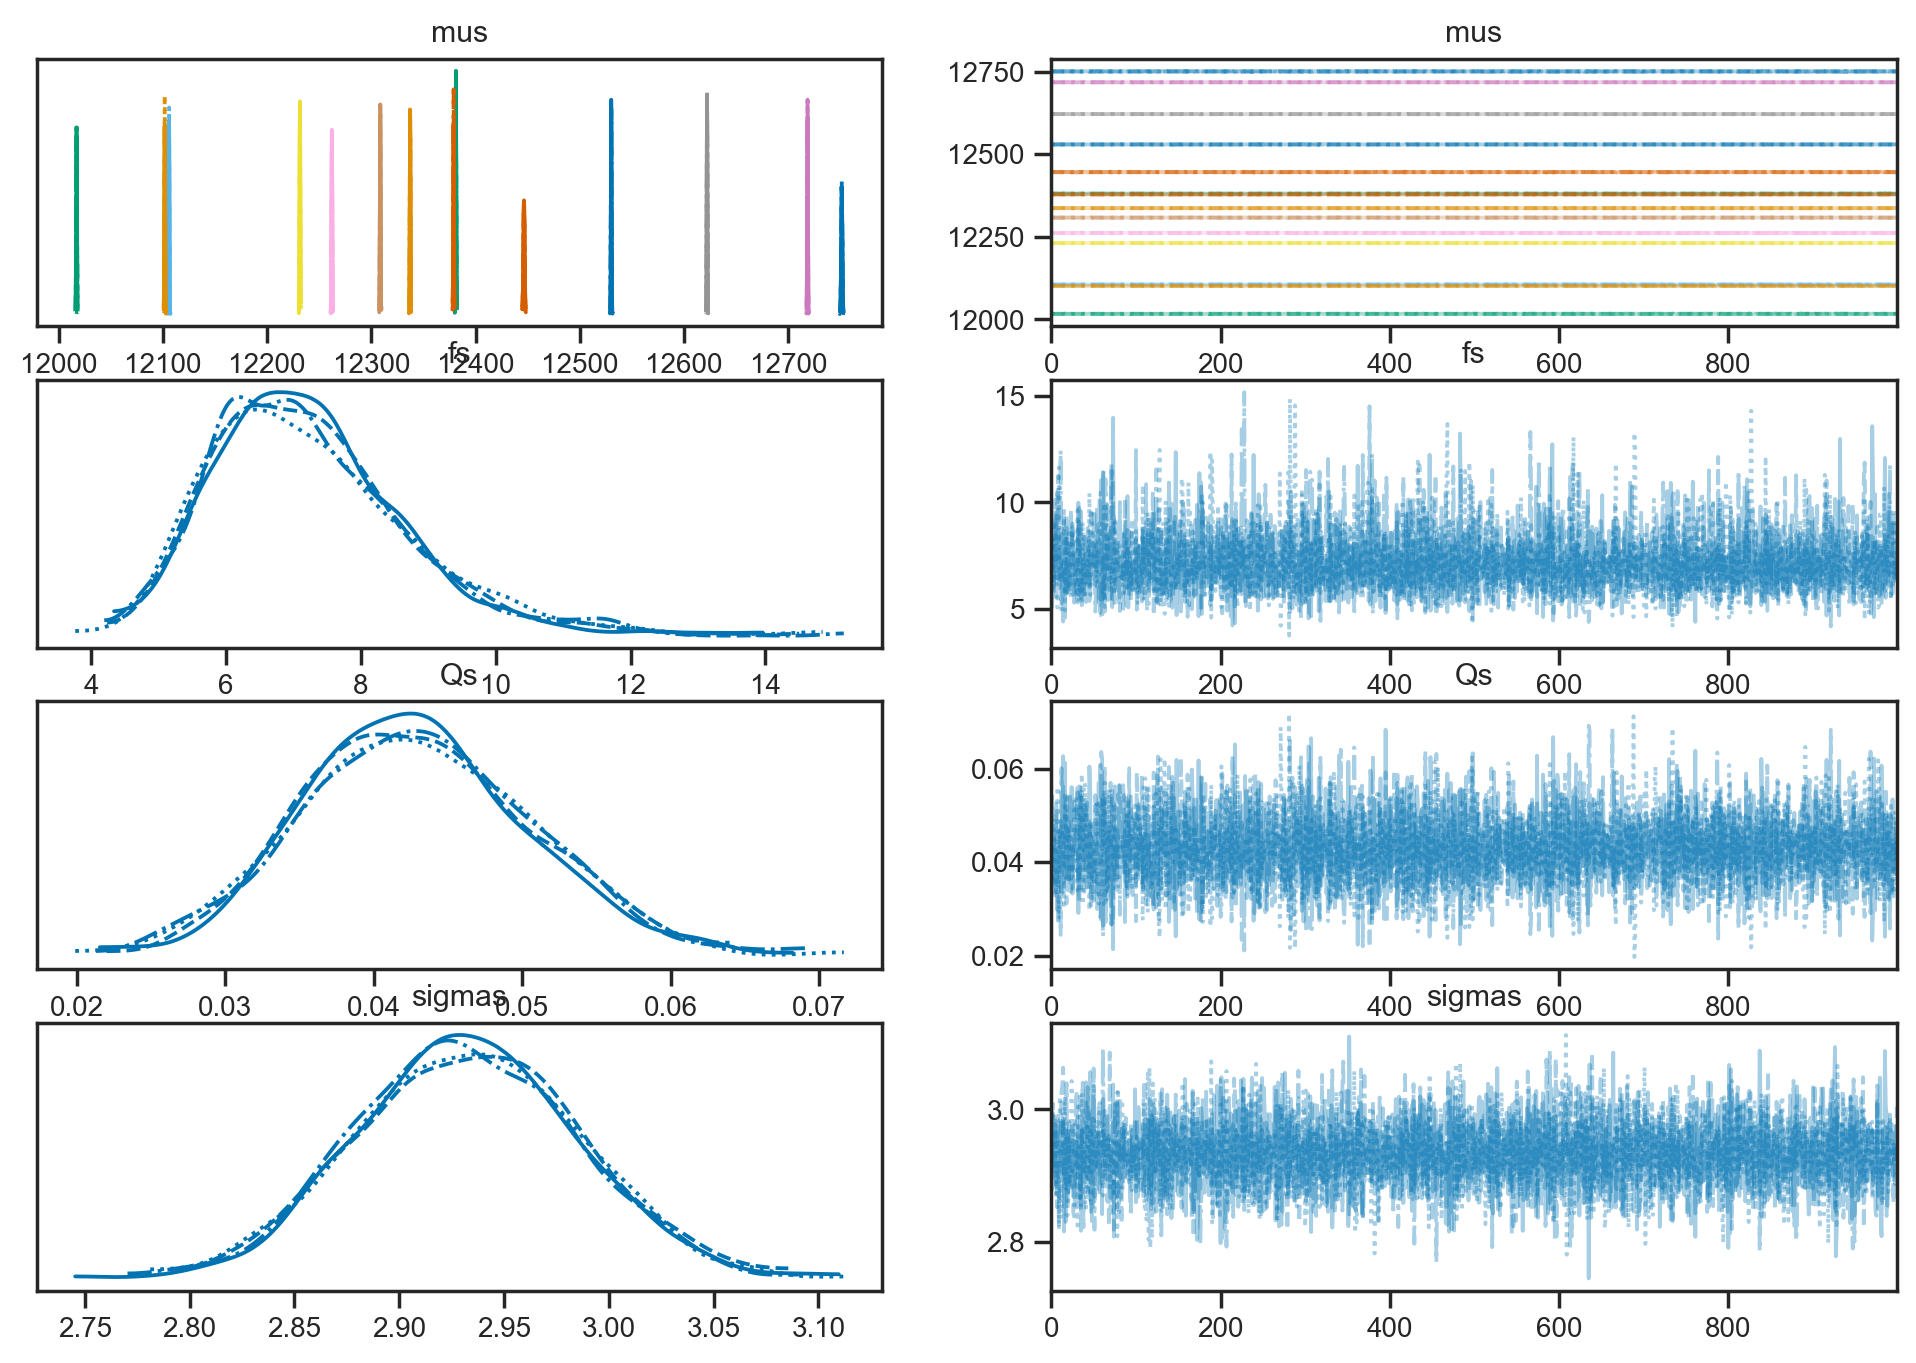

In [51]:
az.plot_trace(trace, var_names=['mus', 'fs', 'Qs', 'sigmas'])

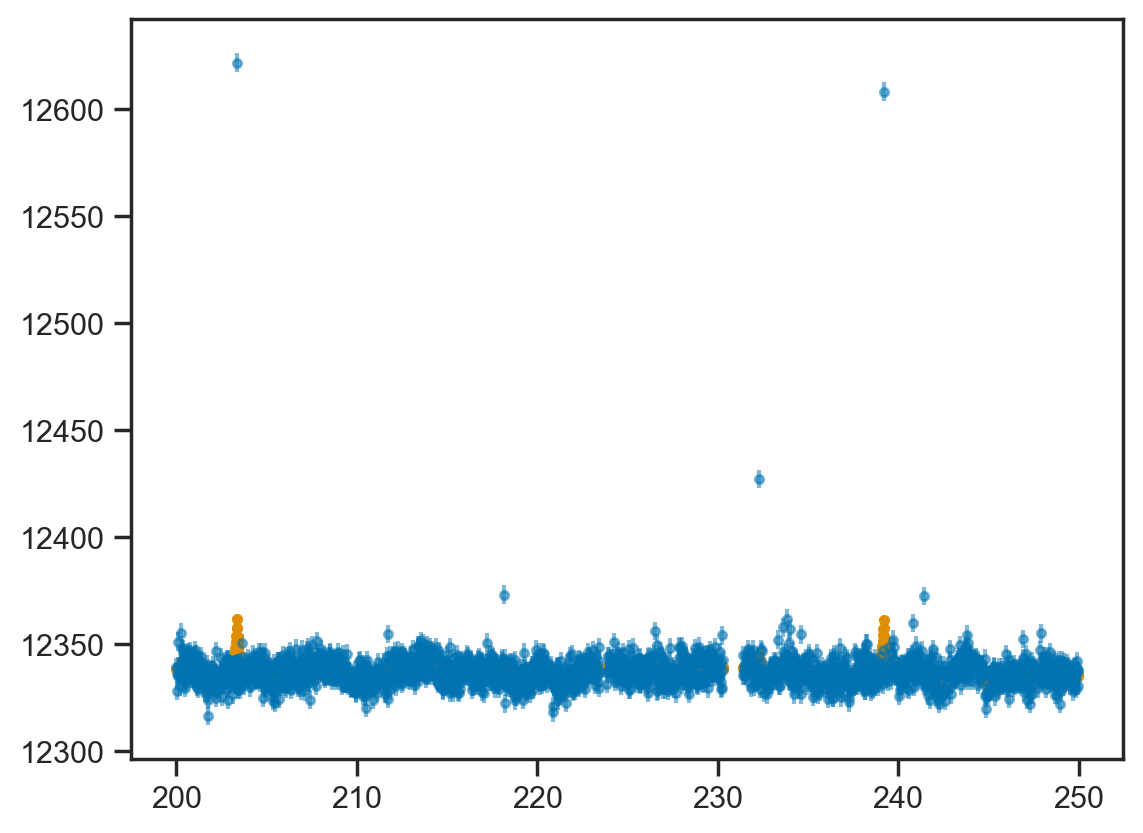

In [53]:
sel = np.abs(times[::thin_data]-225) < 25
plt.errorbar(times[::thin_data][sel], fluxes[::thin_data][sel], yerr=flux_errs[::thin_data][sel], fmt='.', alpha=0.5)
plt.plot(times[::thin_data][sel], trace.posterior['gp_mean_model'].mean(dim=('chain', 'draw')).values.flatten()[sel], '.')

The PSD peaks pretty close to the best-fit location from the literature:

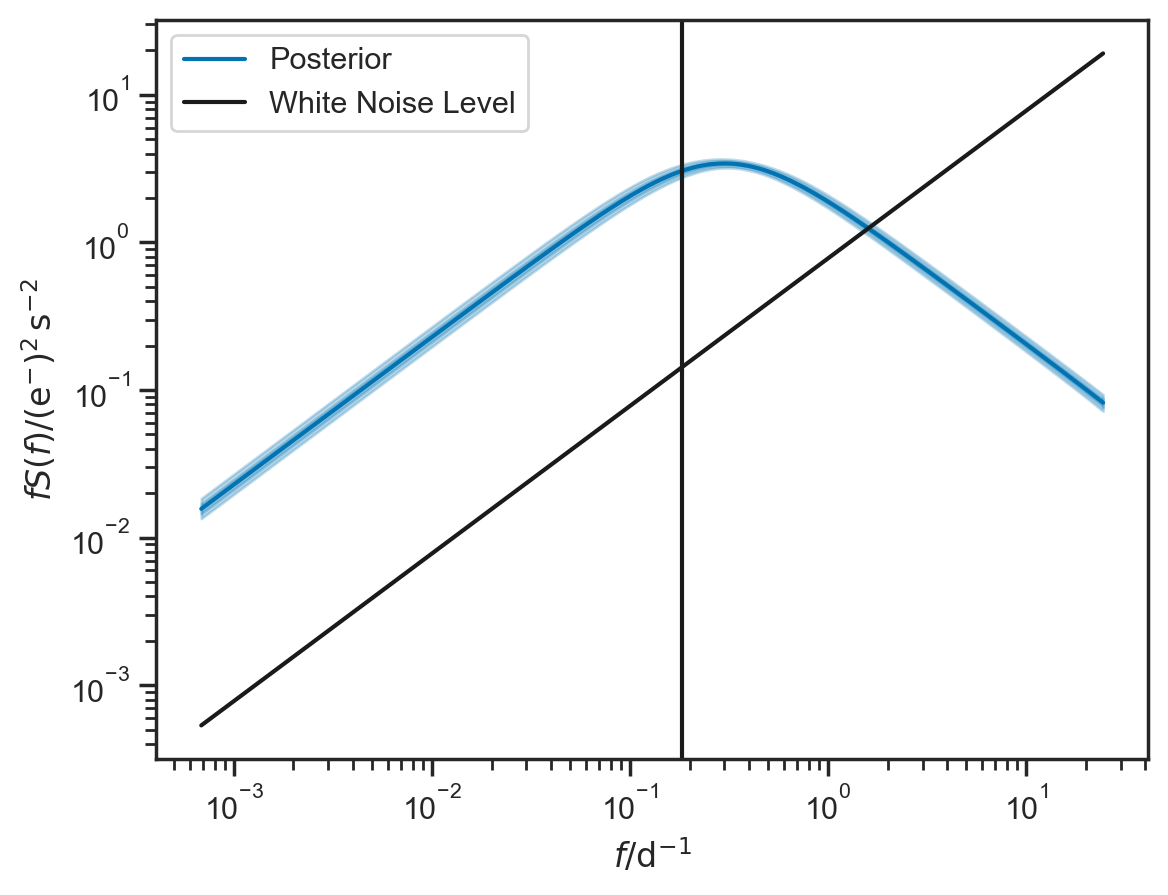

In [56]:
f = trace.posterior.frequencies.values.flatten()
l, = plt.loglog(f, f*trace.posterior.psd.median(dim=('chain', 'draw')).values.flatten(), label='Posterior')
plt.fill_between(f, f*trace.posterior.psd.quantile(0.84, dim=('chain', 'draw')).values.flatten(), f*trace.posterior.psd.quantile(0.16, dim=('chain', 'draw')).values.flatten(), alpha=0.25, color=l.get_color())
plt.fill_between(f, f*trace.posterior.psd.quantile(0.975, dim=('chain', 'draw')).values.flatten(), f*trace.posterior.psd.quantile(0.025, dim=('chain', 'draw')).values.flatten(), alpha=0.25, color=l.get_color())
plt.plot(f, f*(white_noise_variance/fny), 'k', label='White Noise Level')
plt.xlabel(r'$f / \mathrm{d}^{-1}$')
plt.ylabel(r'$f S(f) / \left( \mathrm{e}^{-} \right)^2 \, \mathrm{s}^{-2}$')
plt.legend()

plt.axvline(f_best_literature, color='k')

Because $Q$ is so large, the peak of the PSD and the `f` parameter are quite different:

Text(0.5, 0, '$f / \\mathrm{d}^{-1}$')

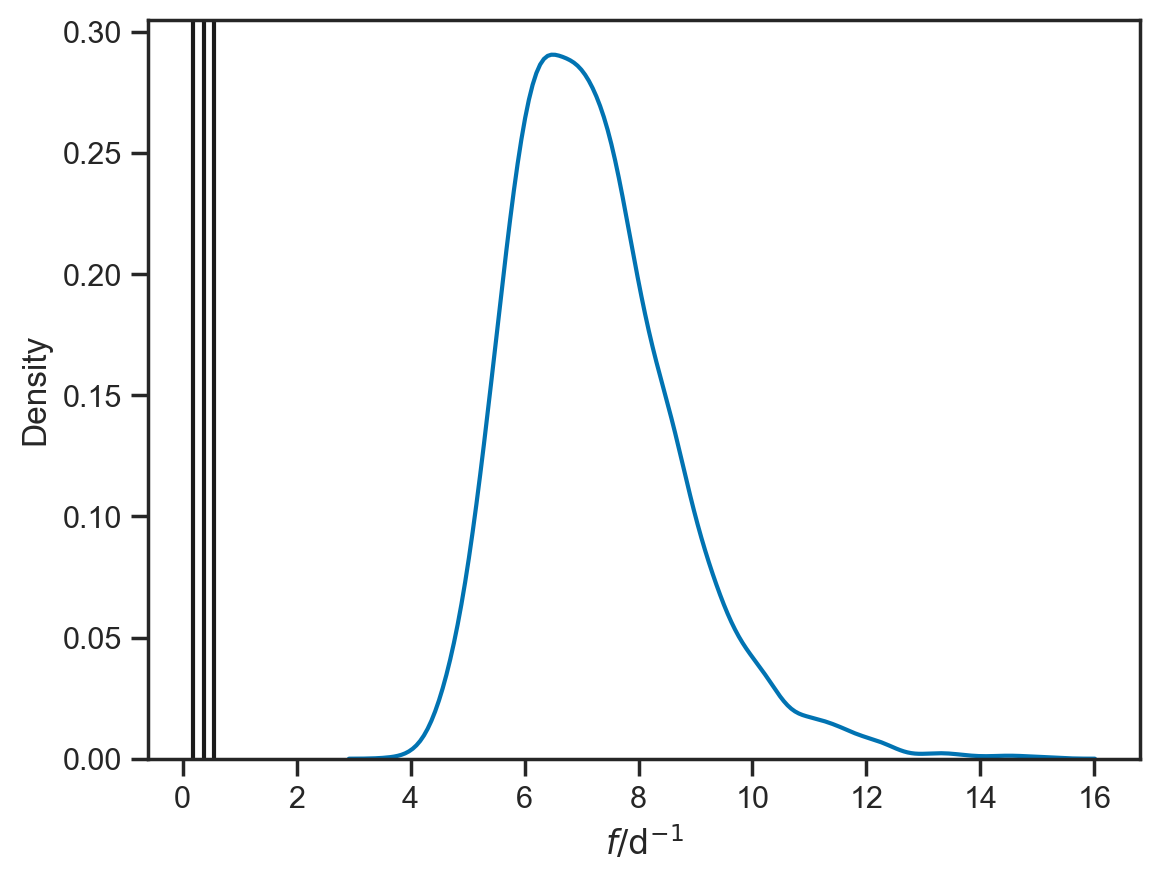

In [57]:
sns.kdeplot(trace.posterior['fs'].values.flatten())
plt.axvline(f_best_literature, color='k')
plt.axvline(2*f_best_literature, color='k')
plt.axvline(3*f_best_literature, color='k')
plt.xlabel(r'$f / \mathrm{d}^{-1}$')

Let's try fitting a two-mode model, at 1 and 2 times the best-fit frequency from the literature.  We will restrict the priors a bit more than above, since we are hunting for peaks at the literature frequencies.

In [58]:
harmonics = [1, 2] 
thin_data = 1 # Set to large value to improve runtime at the cost of more uncertainty.
model2 = harmonic_sho_model(times[::thin_data], fluxes[::thin_data], flux_errs[::thin_data], quarters[::thin_data], f_best_literature, harmonics, quarter_means, quarter_stds, total_std, psd_freq=frequencies, predict_times=times[::thin_data], f_frac_uncert=0.1)

In [59]:
trace2 = pm.sample(tune=1000, draws=1000, cores=4, chains=4, model=model2, progressbar=True, jitter_max_retries=100, init='adapt_full')

Initializing NUTS using adapt_full...
/Users/wfarr/miniconda3/envs/harmonic-lomb-scargle/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:760: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mus_scaled, log_fs_scaled, log_Qs_scaled, log_sigma_scaled]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 373 seconds.


array([[<Axes: title={'center': 'mus'}>, <Axes: title={'center': 'mus'}>],
       [<Axes: title={'center': 'fs'}>, <Axes: title={'center': 'fs'}>],
       [<Axes: title={'center': 'Qs'}>, <Axes: title={'center': 'Qs'}>],
       [<Axes: title={'center': 'sigmas'}>,
        <Axes: title={'center': 'sigmas'}>]], dtype=object)

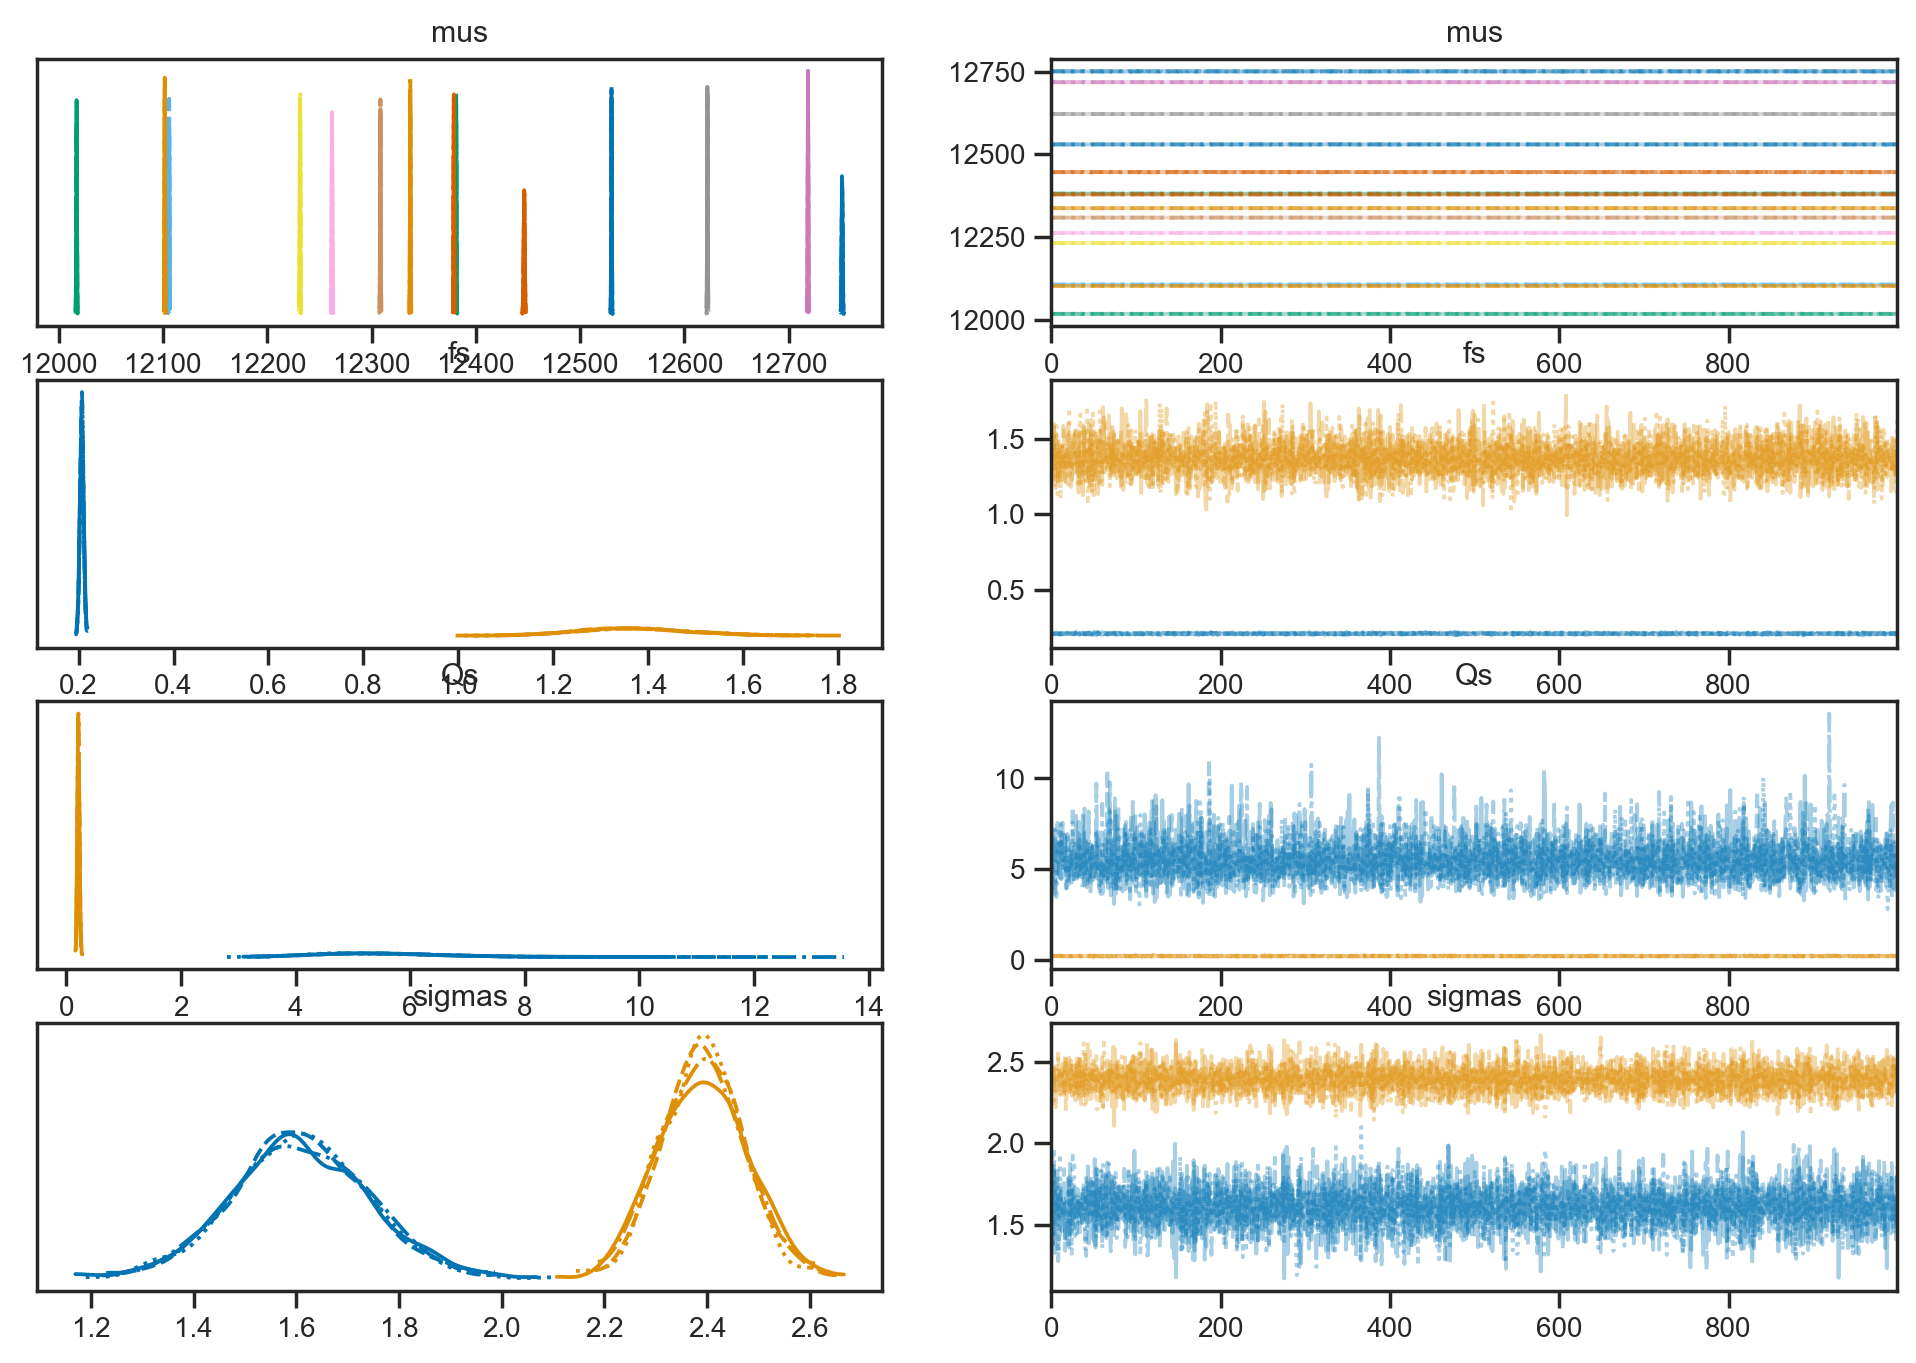

In [60]:
az.plot_trace(trace2, var_names=['mus', 'fs', 'Qs', 'sigmas'])

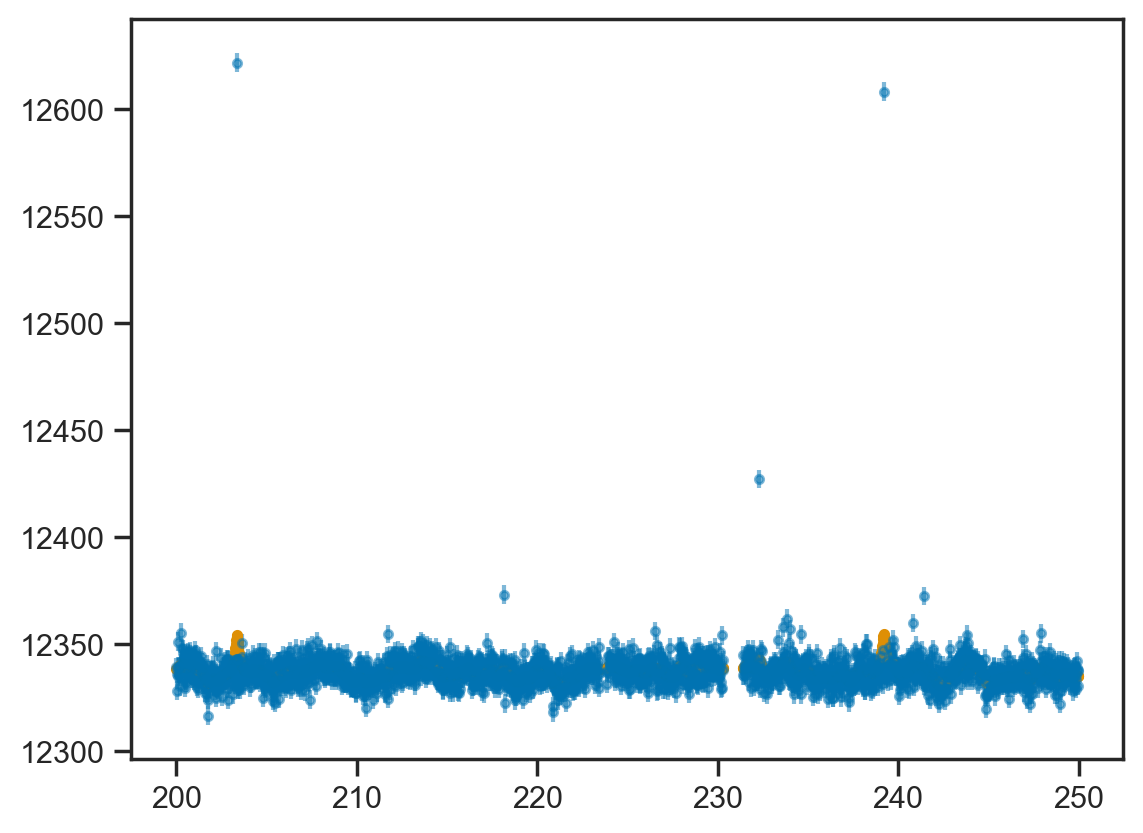

In [62]:
sel = np.abs(times[::thin_data]-225) < 25
plt.errorbar(times[::thin_data][sel], fluxes[::thin_data][sel], yerr=flux_errs[::thin_data][sel], fmt='.', alpha=0.5)
plt.plot(times[::thin_data][sel], trace2.posterior['gp_mean_model'].mean(dim=('chain', 'draw')).values.flatten()[sel], '.')

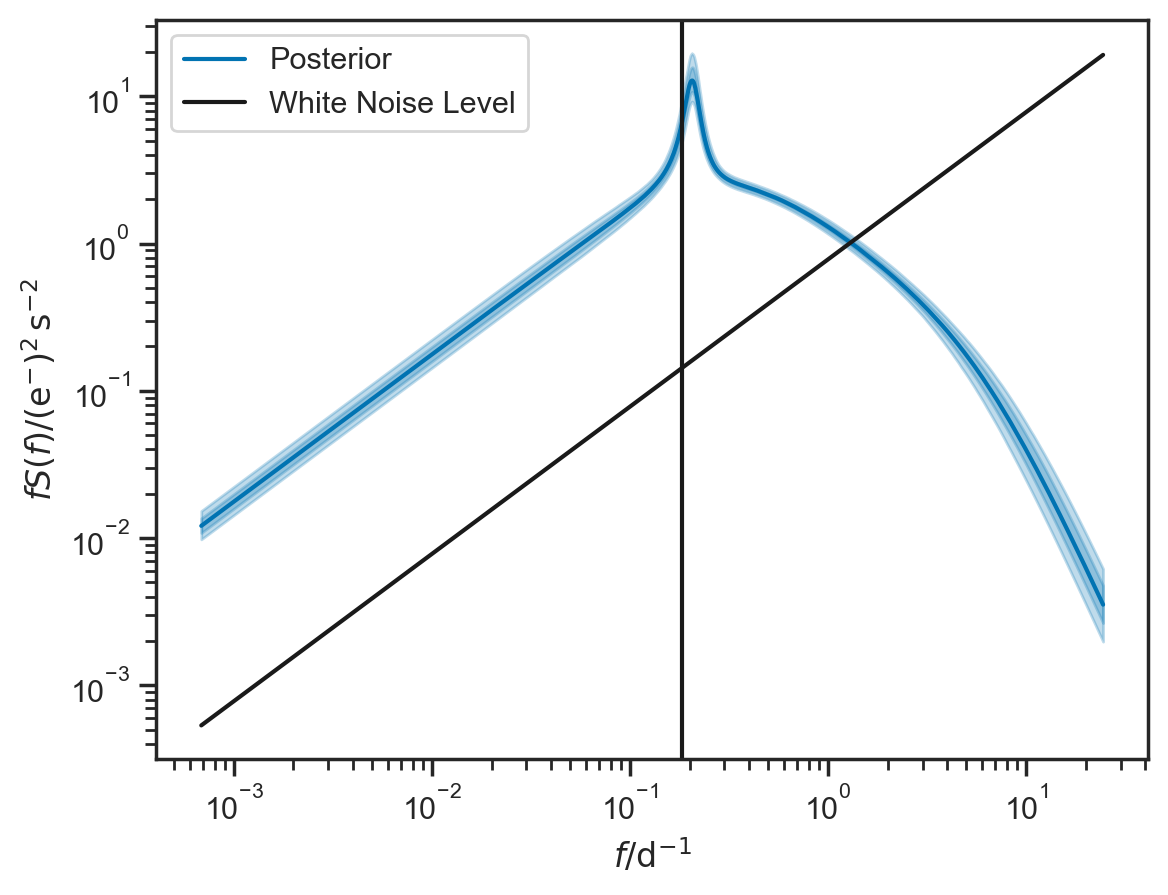

In [64]:
f = trace2.posterior.frequencies.values.flatten()
l, = plt.loglog(f, f*trace2.posterior.psd.median(dim=('chain', 'draw')).values.flatten(), label='Posterior')
plt.fill_between(f, f*trace2.posterior.psd.quantile(0.84, dim=('chain', 'draw')).values.flatten(), f*trace2.posterior.psd.quantile(0.16, dim=('chain', 'draw')).values.flatten(), alpha=0.25, color=l.get_color())
plt.fill_between(f, f*trace2.posterior.psd.quantile(0.975, dim=('chain', 'draw')).values.flatten(), f*trace2.posterior.psd.quantile(0.025, dim=('chain', 'draw')).values.flatten(), alpha=0.25, color=l.get_color())
plt.plot(f, f*(white_noise_variance/fny), 'k', label='White Noise Level')
plt.xlabel(r'$f / \mathrm{d}^{-1}$')
plt.ylabel(r'$f S(f) / \left( \mathrm{e}^{-} \right)^2 \, \mathrm{s}^{-2}$')
plt.legend()

plt.axvline(f_best_literature, color='k')

If we treat $f_1$ as the rotation period, we obtain 

Text(0.5, 1.0, '$P_\\mathrm{rot} = 4.84^{+0.09}_{-0.09} \\, \\mathrm{d}$')

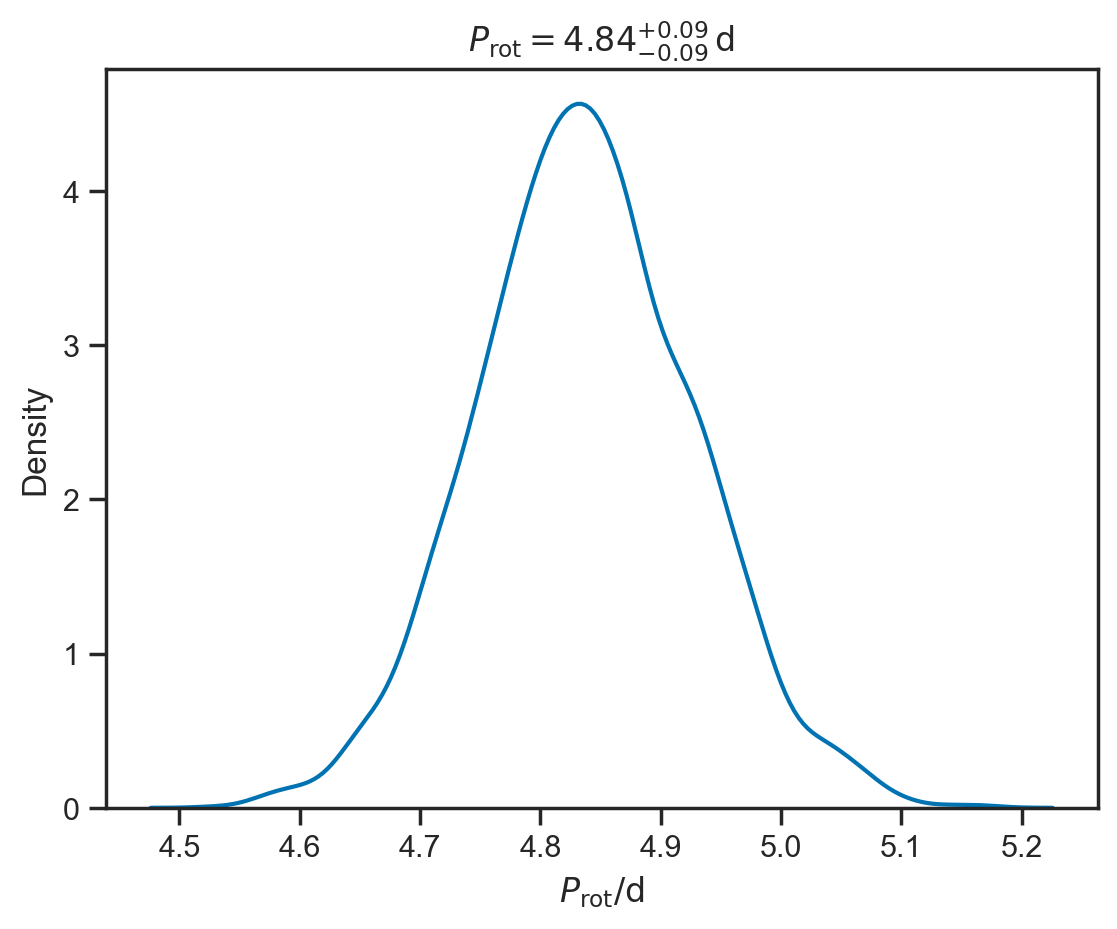

In [65]:
prot = 1/trace2.posterior.fs.sel(harmonics=1).values.flatten()
sns.kdeplot(prot)
plt.xlabel(r'$P_\mathrm{rot} / \mathrm{d}$')
m = np.median(prot)
h = np.quantile(prot, 0.84)
l = np.quantile(prot, 0.16)
plt.title(f'$P_\\mathrm{{rot}} = {m:.2f}^{{+{(h-m):.2f}}}_{{-{(m-l):.2f}}} \, \mathrm{{d}}$')

Can we find a third harmonic?  (Evidently the answer is no---I cannot get a three-harmonic model to fit.)

In [66]:
harmonics = [1, 3] 
thin_data = 1 # Set to large value to improve runtime at the cost of more uncertainty.
model3 = harmonic_sho_model(times[::thin_data], fluxes[::thin_data], flux_errs[::thin_data], quarters[::thin_data], f_best_literature, harmonics, quarter_means, quarter_stds, total_std, psd_freq=frequencies, predict_times=times[::thin_data], f_frac_uncert=0.1)

In [67]:
trace3 = pm.sample(tune=1000, draws=1000, cores=4, chains=4, model=model3, progressbar=True, jitter_max_retries=100, init='adapt_full')

Initializing NUTS using adapt_full...
/Users/wfarr/miniconda3/envs/harmonic-lomb-scargle/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:760: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mus_scaled, log_fs_scaled, log_Qs_scaled, log_sigma_scaled]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 761 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [71]:
trace3.sample_stats.lp.mean(dim='draw')

<xarray.DataArray 'lp' (chain: 4)> Size: 32B
array([-161279.23551852, -162035.30692359, -162035.37499709,
       -162035.71414351])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3

In [73]:
az.plot_trace(trace3.sel(chain=0), var_names=['mus', 'fs', 'Qs', 'sigmas'])

TypeError: len() of unsized object

In [76]:
tp = trace3.posterior.sel(chain=[0])

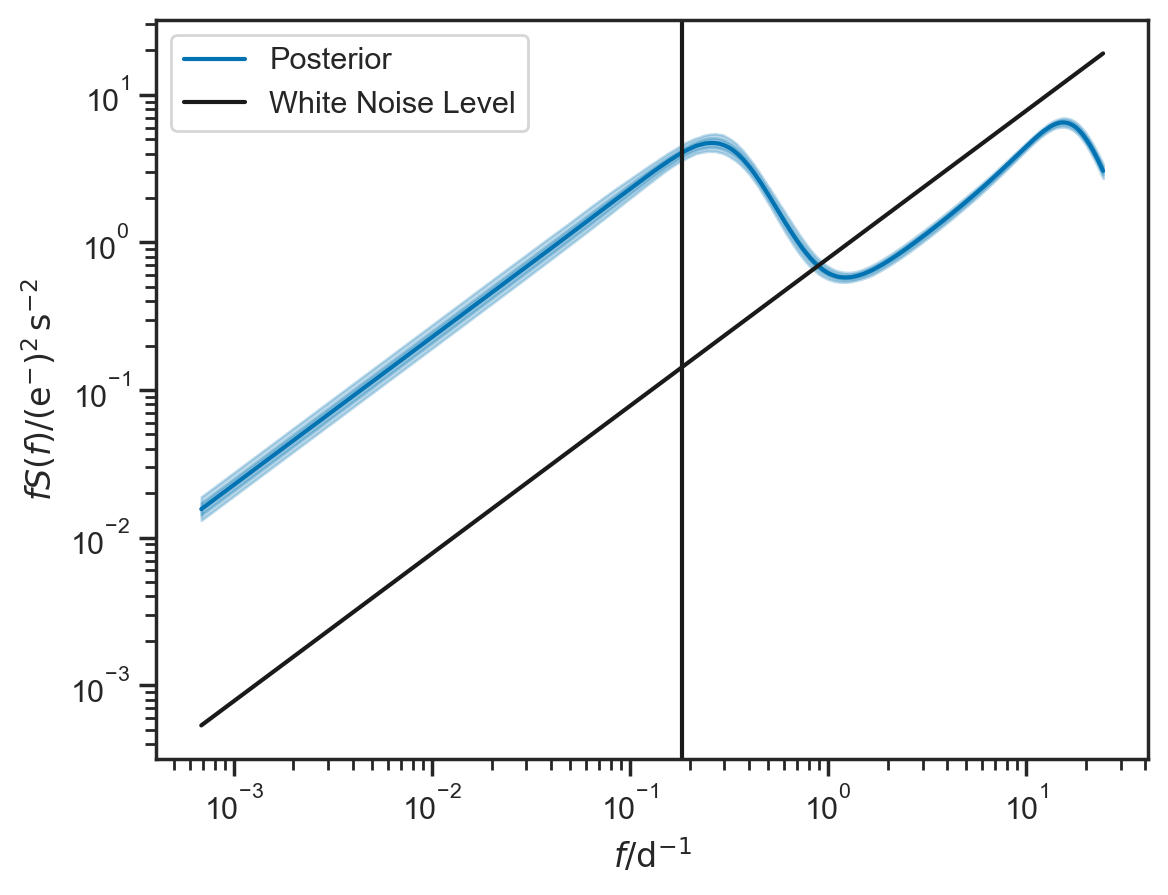

In [77]:
f = trace3.posterior.frequencies.values.flatten()
l, = plt.loglog(f, f*tp.psd.median(dim=('chain', 'draw')).values.flatten(), label='Posterior')
plt.fill_between(f, f*tp.psd.quantile(0.84, dim=('chain', 'draw')).values.flatten(), f*tp.psd.quantile(0.16, dim=('chain', 'draw')).values.flatten(), alpha=0.25, color=l.get_color())
plt.fill_between(f, f*tp.psd.quantile(0.975, dim=('chain', 'draw')).values.flatten(), f*tp.psd.quantile(0.025, dim=('chain', 'draw')).values.flatten(), alpha=0.25, color=l.get_color())
plt.plot(f, f*(white_noise_variance/fny), 'k', label='White Noise Level')
plt.xlabel(r'$f / \mathrm{d}^{-1}$')
plt.ylabel(r'$f S(f) / \left( \mathrm{e}^{-} \right)^2 \, \mathrm{s}^{-2}$')
plt.legend()

plt.axvline(f_best_literature, color='k')

If we treat $f_1$ as the rotation period, we obtain 

Text(0.5, 1.0, '$P_\\mathrm{rot} = 4.84^{+0.09}_{-0.09} \\, \\mathrm{d}$')

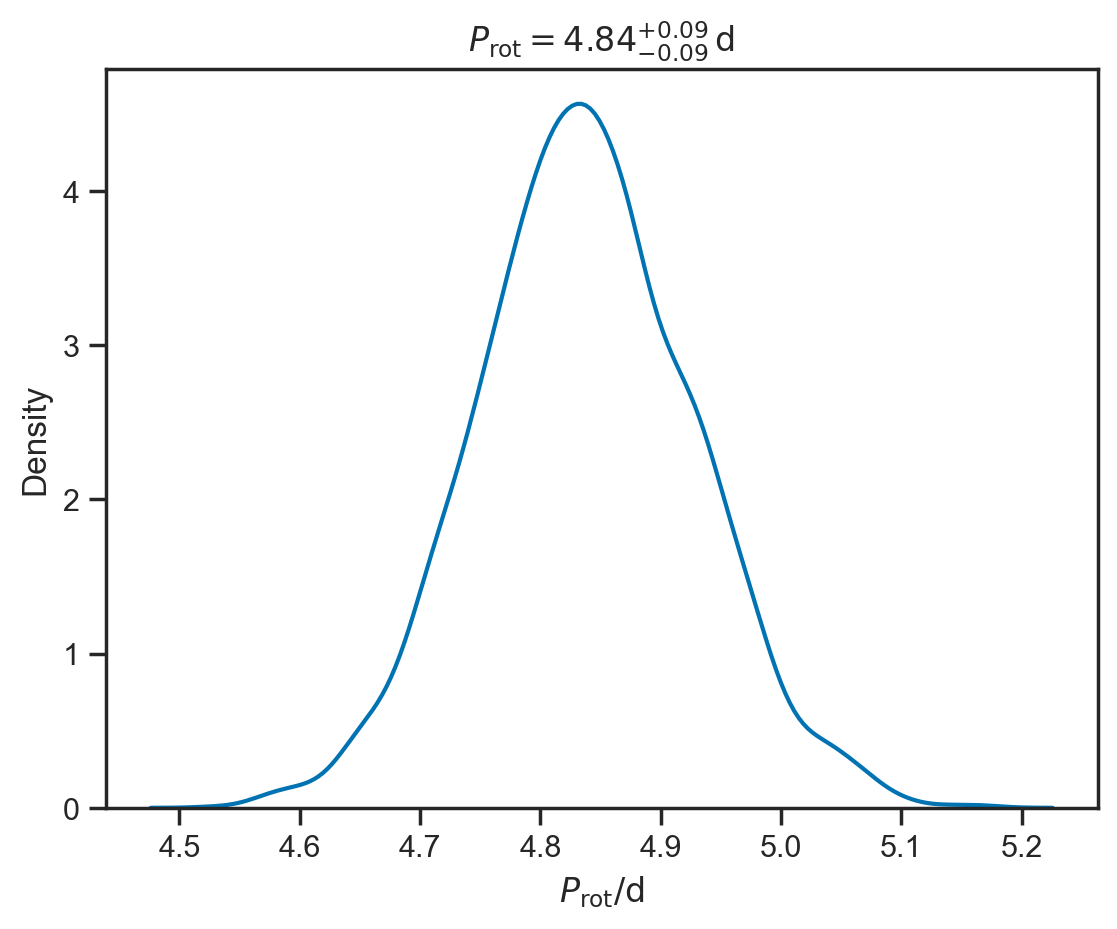

In [ ]:
prot = 1/trace2.posterior.fs.sel(harmonics=1).values.flatten()
sns.kdeplot(prot)
plt.xlabel(r'$P_\mathrm{rot} / \mathrm{d}$')
m = np.median(prot)
h = np.quantile(prot, 0.84)
l = np.quantile(prot, 0.16)
plt.title(f'$P_\\mathrm{{rot}} = {m:.2f}^{{+{(h-m):.2f}}}_{{-{(m-l):.2f}}} \, \mathrm{{d}}$')